# Predict future stock prices through the LSTM Neural Network 

Within the family of Machine Learning tecniques suitable for forecasting when dealing with supervised learning, it is often found Neural Network implementations. 

This work explores a Long Short Term Memory (LSTM) Neural Network to try to forecast future stock prices given a time series from a stock of choice. 

The project is organized in the following way:

1. Loading of data
2. Data preparation 
3. Data training
4. Model implementation
5. Prediciton on the test data
6. Test past predictions
7. Predict tomorrow

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandas_datareader as pdr
import datetime as dt
import matplotlib.dates as mdates

from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

## 1. Loading data

We will refer to the *stooq* database directly importing the time series. 

In [12]:
company = 'JD'

start = dt.datetime(2020, 1, 1)
end = dt.datetime(2022, 1, 1)

df = pdr.DataReader(company, 'stooq', start, end)
df['Pct_Change'] = df['Close'].pct_change() * 100
df

,Open,High,Low,Close,Volume,Pct_Change
Date,,,,,,
2021-12-31,67.8851,69.2024,67.6412,68.3730,5.581413e+06,NaN
2021-12-30,64.2747,69.9342,64.1966,68.6950,1.424769e+07,0.470946
2021-12-29,64.8895,65.3871,63.1330,64.0405,6.629820e+06,-6.775602
2021-12-28,65.6701,65.6896,63.9722,64.2747,9.493405e+06,0.365706
2021-12-27,66.0638,67.2118,65.9091,66.0701,7.882815e+06,2.793323
...,...,...,...,...,...,...
2020-01-08,37.0992,37.9091,37.0602,37.3724,1.172185e+07,-1.542498
2020-01-07,37.1577,37.6749,36.7284,37.3919,1.046844e+07,0.052178
2020-01-06,36.5528,37.1577,36.4747,37.0797,9.988262e+06,-0.834940


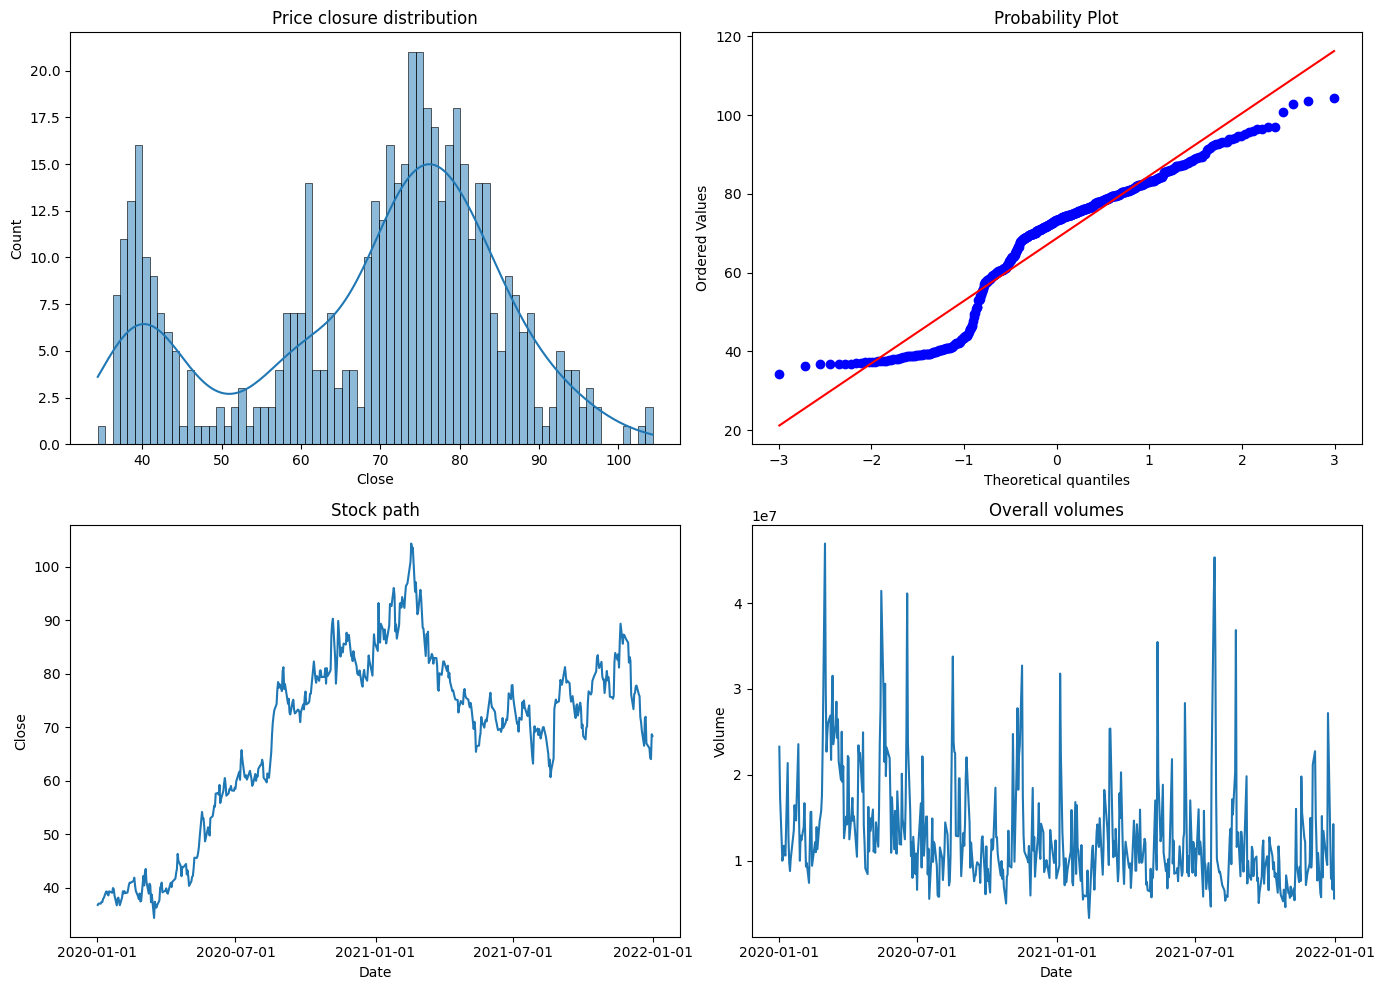

In [13]:
fig, axes = plt.subplots(2, 2, figsize = (14, 10))

axes[0,0].set_title('Price closure distribution')
sns.histplot(data = df.Close,
             bins = 75,
             kde = True,
             ax = axes[0,0])

axes[0,1].set_title('Close Q-Q Plot')
stats.probplot(df.Close,
               plot = axes[0,1])

axes[1,0].set_title('Stock path')
sns.lineplot(data = df.Close,
             ax = axes[1,0])
x_ticks = axes[1,0].get_xticks()
x_ticks_selected = x_ticks[::(len(x_ticks) // 4)]
axes[1,0].set_xticks(x_ticks_selected)


axes[1,1].set_title('Overall volumes')
sns.lineplot(data = df.Volume,
             ax = axes[1,1])
x_ticks = axes[1,1].get_xticks()
x_ticks_selected = x_ticks[::(len(x_ticks) // 4)]
axes[1,1].set_xticks(x_ticks_selected)

plt.tight_layout()
plt.show()

## 2. Data pre-processing

The series is rescaled using the `MinMaxScaler` function to obtain values between $(0, 1)$. 

In [14]:
scaler = MinMaxScaler(feature_range = (0, 1))

scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

## 3. Data training

from the `scaled_data` $[x_t, ..., x_T]$ dimension $[(T-t)$ x $1]$ we organize the training data in the following way:

- prediction days = $k$
- `x_train` = $[[x_1, ..., x_k], 
               ..., 
               [(x_{n-k}, ..., x_n]]$
- `y_train` = $[x_k, ..., x_{(T-t)}]$

`x_train` is now of dimension $[k$ x $1$ x $(T-t-k)]$ while `y_train` is of $[(T-t+k)$ x $1]$ which correspond to the input and the output of the network respectively. The `x_train` then transformed into a `NumPy` array holds the shape:
1. *samples*: number of training samples
2. *timesops*: number of previous day's data in each sample ($k$)
3. *features*: number of features (here 1 representing the close price)

`y_train` represents in few words the $k$-th value which correspond to the last value for each single matrix in `x_train`. The goal here is to train the $k$-th previous data on each element of the `y_train` array. 

In [15]:
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):    
    x_train.append(scaled_data[x - prediction_days : x, 0]) 
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## 4. Model implementation

We use a linear stack of layers added one after another (Sequential), the number of nodes is adjustable. The model returns a sequence instead of just an output. A regularization technique is implemented adding a dropout layer to prevent overfitting. 

A final fully connected layer with a single node is set to obtain the prediction of the next closing value. The optimization algorithm is set to `adam`, while the loss parameter is set to be the *Mean Squared Error*.
The input, output, number of iteration of the training data (*epochs*) and number of samples per gradient update (`batch_size`) is set using the `model.fit` command.

In [16]:
model = Sequential()  # Initializes a sequen model (linear stack of layers)

model.add(LSTM(units = 50, 
               return_sequences = True, 
               input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) 
model.compile(optimizer = 'adam', loss ='mean_squared_error')
model.fit(x_train, y_train, epochs = 25, batch_size = 32)

Epoch 1/25
14/14 [==============================] - 6s 72ms/step - loss: 0.0651
Epoch 2/25
14/14 [==============================] - 1s 69ms/step - loss: 0.0195
Epoch 3/25
14/14 [==============================] - 1s 71ms/step - loss: 0.0112
Epoch 4/25
14/14 [==============================] - 1s 69ms/step - loss: 0.0087
Epoch 5/25
14/14 [==============================] - 1s 71ms/step - loss: 0.0077
Epoch 6/25
14/14 [==============================] - 1s 67ms/step - loss: 0.0087
Epoch 7/25
14/14 [==============================] - 1s 68ms/step - loss: 0.0084
Epoch 8/25
14/14 [==============================] - 1s 67ms/step - loss: 0.0068
Epoch 9/25
14/14 [==============================] - 1s 67ms/step - loss: 0.0074
Epoch 10/25
14/14 [==============================] - 1s 67ms/step - loss: 0.0062
Epoch 11/25
14/14 [==============================] - 1s 69ms/step - loss: 0.0071
Epoch 12/25
14/14 [==============================] - 1s 67ms/step - loss: 0.0065
Epoch 13/25
14/14 [==================

## 5. Testing the data

The model is now trained and ready to be used. We upload some data to test the model. We retrieve data from the day after the dataset just used until now and concatenate it to the existing dataset. 

`model_inputs` is again a three-dinension suitable for the network. `x_train` is put into the model and the results are stored in the `predicted_prices` array. 

A comparison between the actual prices versus the forecasted prices is plotted. Remember that each price predicted is the stock price predicted by the neural network based on the past 60 prices (since the network has been trained feeding him datas as inputs and the $60$-th closing price as input.

12/12 [==============================] - 1s 28ms/step


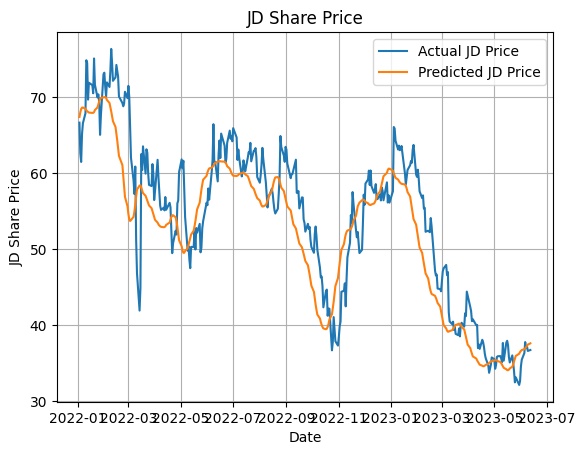

In [18]:
test_start = dt.datetime(2022, 1, 1)
test_end = dt.datetime.now()  

test_data = pdr.DataReader(company, 'stooq', test_start, test_end)

actual_prices = test_data['Close'].values
# Combine the data from training and test 
total_dataset = pd.concat((df['Close'], test_data['Close']), axis = 0)


model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
# Like this we are able to start in the index omitting the test data and the 
# extra 'prediction_days'
model_inputs = model_inputs.reshape(-1, 1)  #unknown no. of rows, 1 no. of column
model_inputs = scaler.transform(model_inputs) # We normalize the new test data

# Make predictions on test data

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x - prediction_days:x, 0])  # Same iteration as before
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# predictions on the test data using the trained modelThe 
predicted_prices = model.predict(x_test) 
predicted_prices

predicted_prices = scaler.inverse_transform(predicted_prices)
predicted_prices

plt.plot(test_data.index, actual_prices, label=f'Actual {company} Price')
plt.plot(test_data.index, predicted_prices, label=f'Predicted {company} Price')
plt.title(f'{company} Share Price')
plt.xlabel('Date')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.grid()
plt.show()

## 6. Tomorrow prediction

Finally, following the previous style, the last 60 days closing prices are retrieved to predict tomorrow's closing price. 

In [19]:
# Predict Next Day

# selects a slice of model_inputs that corresponds to the most recent 
# prediction_days data points. 
# This represents the input data for which you want to make predictions.
real_data = model_inputs[- prediction_days:]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (1, prediction_days, 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

1/1 [==============================] - 0s 32ms/step
Prediction: [[66.74848]]
